# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2020/06/09<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Setup

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [18]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [19]:
dataframe.shape

(303, 14)

Here's a preview of a few samples:

In [20]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

Let's split the data into a training and validation set:

In [21]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [22]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [23]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=47>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=110>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=275>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=118>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Let's batch the datasets:

In [24]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers


The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and reserve
 an output index for unkown input values.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Finally, the following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `encode_string_categorical_feature` to first turn string inputs into integer indices,
then one-hot encode these integer indices.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.

In [25]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

In [26]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Let's visualize our connectivity graph:

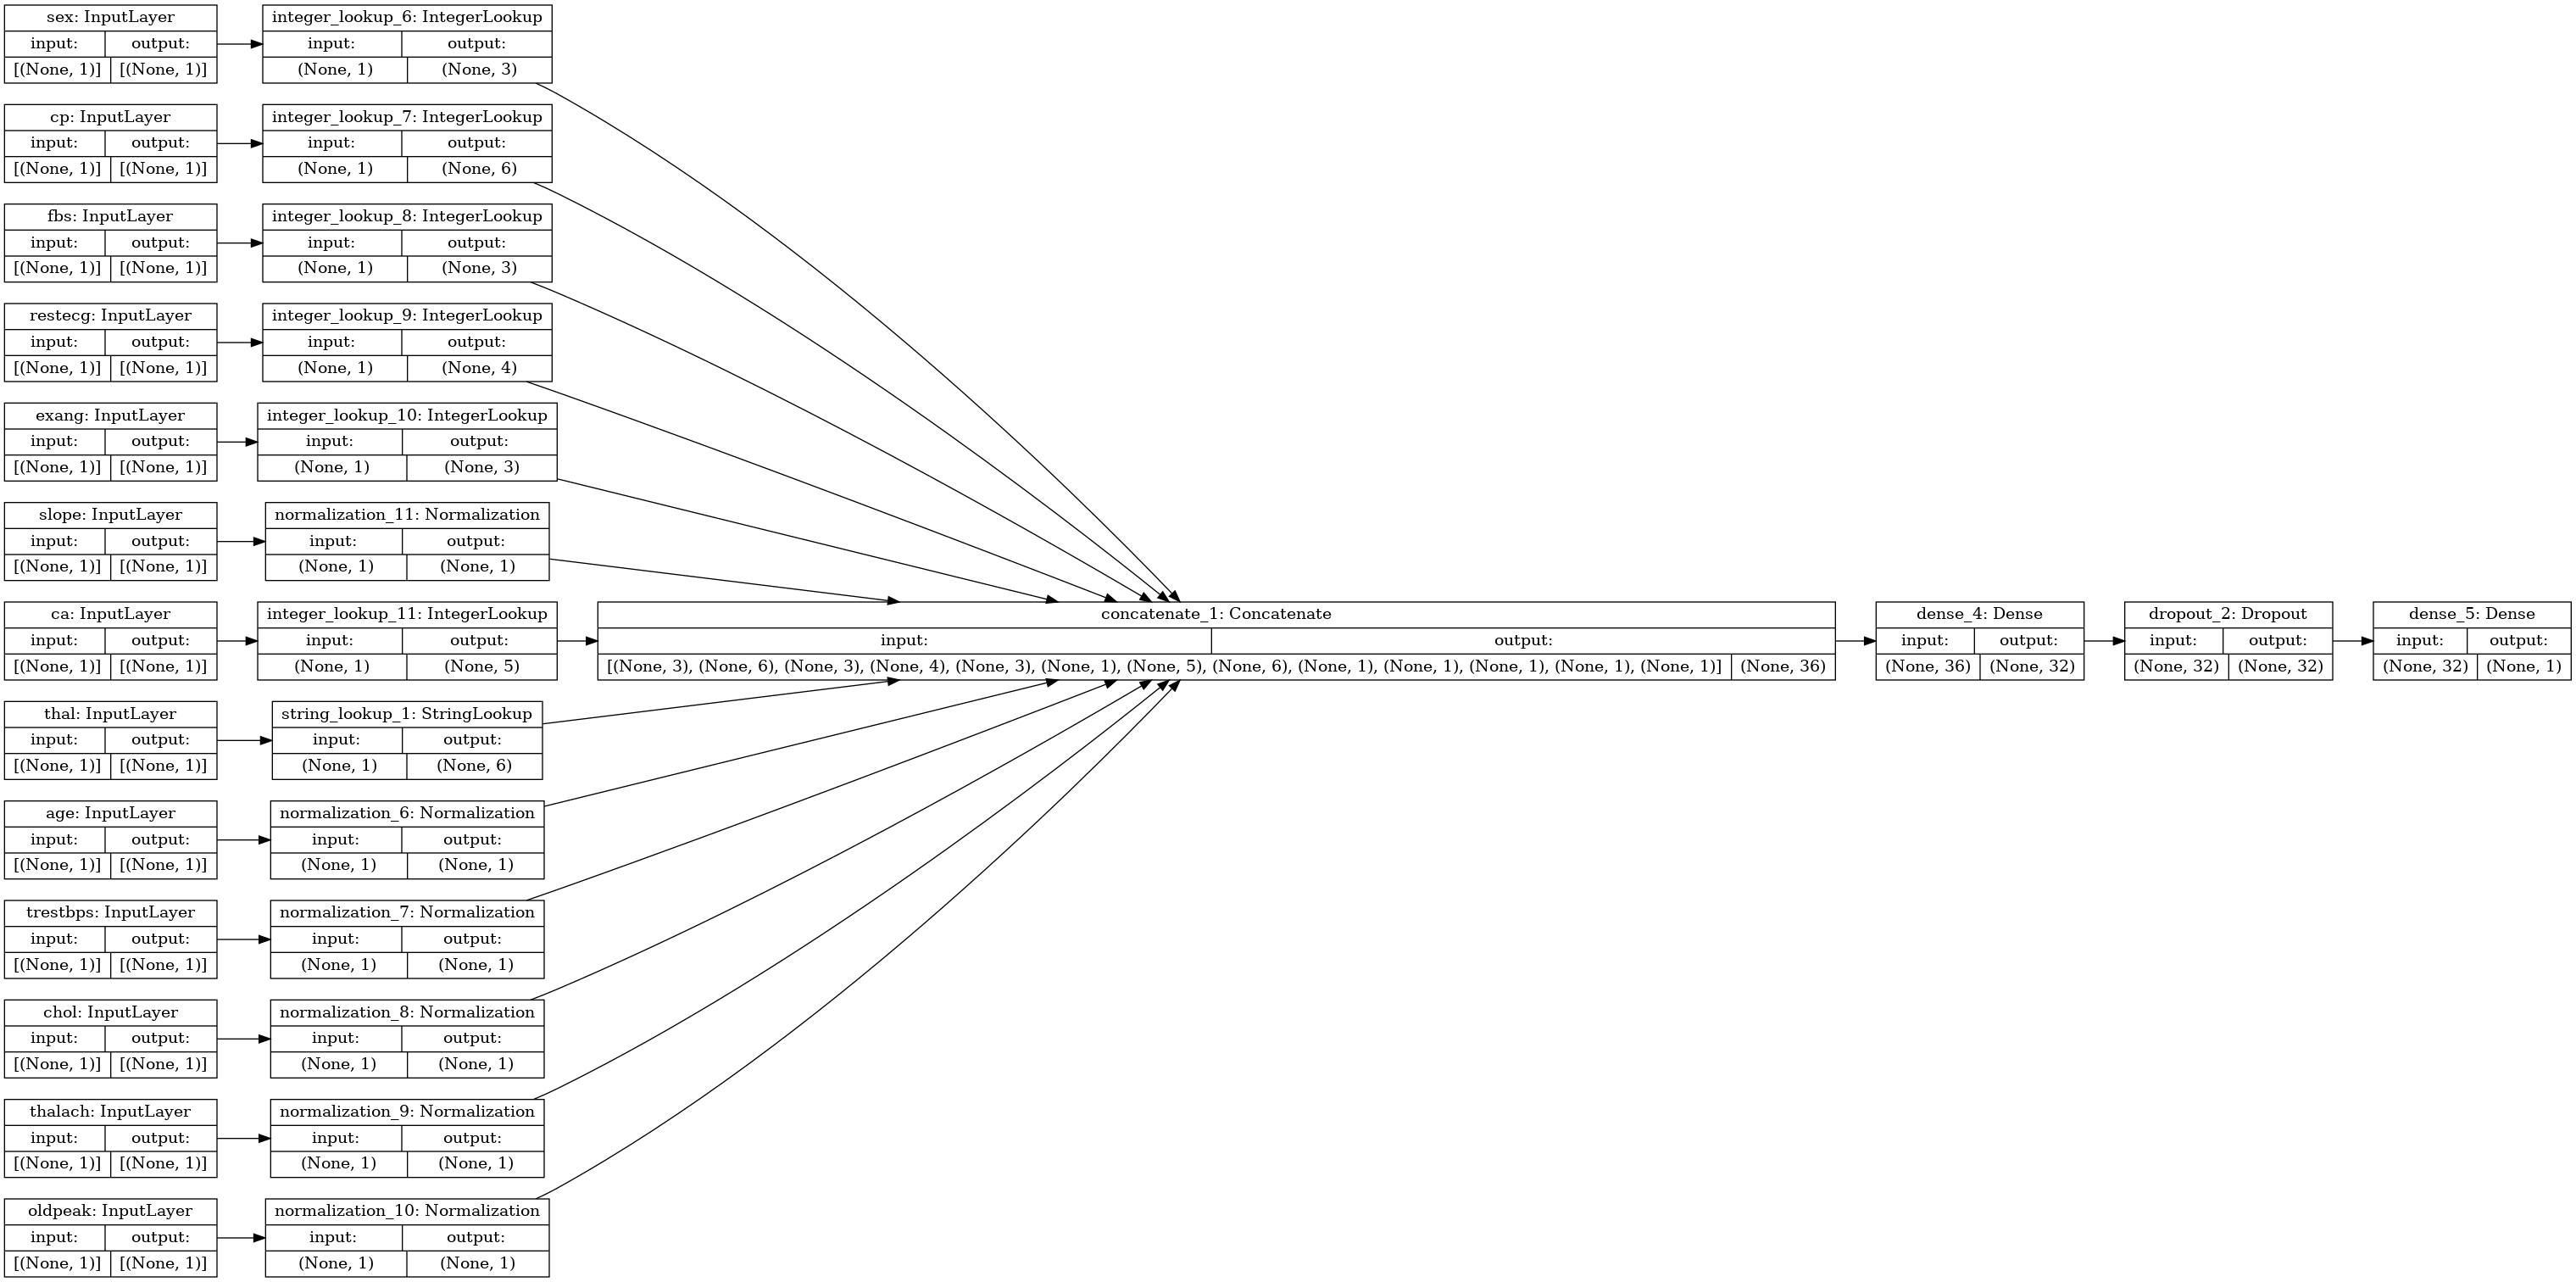

In [27]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [28]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


AttributeError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:845 step_function  **
        write_scalar_summaries(outputs, step=model._train_counter)  # pylint: disable=protected-access
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2977 write_scalar_summaries
        tf.summary.scalar('batch_' + name, value, step=step)

    AttributeError: module 'tensorflow.compat.v2.summary' has no attribute 'scalar'


We quickly get to 80% validation accuracy.

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [ ]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

In [ ]:
import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(
    dataframe=dataframe,
    stats_options=tfdv.StatsOptions(
        label_feature='Target',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [ ]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

In [ ]:
import os
raw_schema_location = os.path.join('/home/jupyter/training/src/', 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

In [ ]:
from google.cloud import aiplatform as vertex_ai
vertex_ai.init(
    project='ml-pipelines-showcase',
    location='us-central1'
)

In [ ]:
vertex_ai.TabularDataset.create(display_name="heart",gcs_source="gs://mlops-vertex-jsk/simple-training/heart.csv")

In [ ]:
TENSORBOARD_DISPLAY_NAME = 'tb-hearts'
EXPERIMENT_NAME = 'hearts'


tensorboard_resource = vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
tensorboard_resource_name = tensorboard_resource.gca_resource.name
print("TensorBoard resource name:", tensorboard_resource_name)

In [ ]:
REMOVE_EXPERIMENT_ARTIFACTS = False
EXPERIMENT_ARTIFACTS_DIR="gs://mlops-vertex-jsk/simple-training/experiments/"

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")
print("Experiment directory:", EXPERIMENT_ARTIFACTS_DIR)

In [ ]:


vertex_ai.init(
    project='ml-pipelines-showcase',
    location='us-central1',
    staging_bucket='gs://mlops-vertex-ai/simple-training/staging/',
    experiment=EXPERIMENT_NAME
)

In [ ]:
from datetime import datetime

run_id = f"run-hearts-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

In [ ]:
LOG_DIR= 'gs://mlops-vertex-ai/simple-training/logging/'

def redesign_model(num_neurons=32, learning_rate=0.1, dropout=0.5):
    
    x = layers.Dense(num_neurons, activation="relu")(all_features)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logging/")

    model = keras.Model(all_inputs, output)
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
new_model=redesign_model(64,0.1,0.1)

In [ ]:
hyperparams = {
    "hidden_units": 64,
    "epochs":50,
    "learning_rate":0.1,
    "dropout":0.1,
}
vertex_ai.log_params(hyperparams)

In [ ]:
LOG_DIR= f'gs://mlops-vertex-ai/simple-training/logging/'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/jupyter/logging/')

new_model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[tensorboard_callback])

In [ ]:
loss,accuracy=new_model.evaluate(val_ds)

In [ ]:
vertex_ai.log_metrics(
    {"val_loss": loss, "val_accuracy": accuracy})

In [ ]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True